# Capstone Project - Paris Neighborhoods
## Selecting neighborhood for hotel using clusters

### 0. Installing libriaries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         393 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0

The following packages will be UPDATED:

  ca-certificates                     2020.4.5

### 1. Downloading and preparing data

Downloading France boroughs

In [2]:
 !wget -q -O 'france_data.json' https://www.data.gouv.fr/fr/datasets/r/e88c6fda-1d09-42a0-a069-606d3259114e
print('Data downloaded!')

Data downloaded!


In [3]:
with open('france_data.json') as json_data:
    france_data = json.load(json_data)

In [4]:
france_data[0]

{'datasetid': 'correspondances-code-insee-code-postal',
 'recordid': '2bf36b38314b6c39dfbcd09225f97fa532b1fc45',
 'fields': {'code_comm': '645',
  'nom_dept': 'ESSONNE',
  'statut': 'Commune simple',
  'z_moyen': 121.0,
  'nom_region': 'ILE-DE-FRANCE',
  'code_reg': '11',
  'insee_com': '91645',
  'code_dept': '91',
  'geo_point_2d': [48.750443119964764, 2.251712972144151],
  'postal_code': '91370',
  'id_geofla': '16275',
  'code_cant': '03',
  'geo_shape': {'type': 'Polygon',
   'coordinates': [[[2.238024349288764, 48.735565859837095],
     [2.226414985434264, 48.75003536744732],
     [2.22450256558849, 48.75882853410981],
     [2.232859032169924, 48.76598806763034],
     [2.250043759055985, 48.761213267519565],
     [2.269288614654887, 48.76063999654954],
     [2.276145972515501, 48.75666127305422],
     [2.283691112862691, 48.748081131389654],
     [2.274517407535147, 48.74072222671912],
     [2.238024349288764, 48.735565859837095]]]},
  'superficie': 999.0,
  'nom_comm': 'VERRIERE

Converting downloaded data into a dataframe

In [5]:
# define the dataframe columns
column_names = ['nom_region', 'nom_dept', 'code_dept', 'postal_code', 'code_cant', 'nom_comm', 'code_arr', 'population', 'lat_bor', 'lon_bor'] 

# instantiate the dataframe
france = pd.DataFrame(columns=column_names)

In [6]:
for data in france_data:
    nom_region = data['fields']['nom_region']
    nom_dept = data['fields']['nom_dept'] 
    code_dept = data['fields']['code_dept']
    postal_code = data['fields']['postal_code']
    code_cant = data['fields']['code_cant']
    nom_comm = data['fields']['nom_comm']
    code_arr = data['fields']['code_arr']
    population = data['fields']['population']
    
    data_latlon = data['fields']['geo_point_2d']
    lat = data_latlon[1]
    lon = data_latlon[0]
    
    france = france.append({'nom_region': nom_region,
                                          'nom_dept': nom_dept,
                                          'code_dept': code_dept,
                                          'postal_code': postal_code,
                                          'code_cant': code_cant,
                                          'nom_comm': nom_comm,
                                          'code_arr': code_arr,
                                          'population': population,
                                          'lat_bor': lat,
                                          'lon_bor': lon}, ignore_index=True) 

In [7]:
france.head()

,nom_region,nom_dept,code_dept,postal_code,code_cant,nom_comm,code_arr,population,lat_bor,lon_bor
0,ILE-DE-FRANCE,ESSONNE,91,91370,03,VERRIERES-LE-BUISSON,3,15.5,2.251713,48.750443
1,ILE-DE-FRANCE,SEINE-ET-MARNE,77,77126,20,COURCELLES-EN-BASSEE,3,0.2,3.052941,48.412561
2,ILE-DE-FRANCE,ESSONNE,91,91730,09,MAUCHAMPS,1,0.3,2.197182,48.527268
3,ILE-DE-FRANCE,SEINE-ET-MARNE,77,77400,14,LAGNY-SUR-MARNE,5,20.2,2.709781,48.873070
4,ILE-DE-FRANCE,SEINE-ET-MARNE,77,77160,25,SAINT-HILLIERS,3,0.4,3.258236,48.628915


In [8]:
france.shape

(1300, 10)

As we can see from the dataset's shape - it includes all the boroughs in France. Let's select only those that are located in Paris.

In [9]:
paris_data = france[france['nom_dept'] == 'PARIS'].reset_index(drop=True)
paris_data.head()

,nom_region,nom_dept,code_dept,postal_code,code_cant,nom_comm,code_arr,population,lat_bor,lon_bor
0,ILE-DE-FRANCE,PARIS,75,75009,23,PARIS-9E-ARRONDISSEMENT,1,60.3,2.337460,48.876896
1,ILE-DE-FRANCE,PARIS,75,75010,24,PARIS-10E-ARRONDISSEMENT,1,95.9,2.361113,48.876029
2,ILE-DE-FRANCE,PARIS,75,75016,30,PARIS-16E-ARRONDISSEMENT,1,169.4,2.262100,48.860399
3,ILE-DE-FRANCE,PARIS,75,75002,16,PARIS-2E-ARRONDISSEMENT,1,22.4,2.344107,48.867903
4,ILE-DE-FRANCE,PARIS,75,75011,25,PARIS-11E-ARRONDISSEMENT,1,152.7,2.378741,48.859415


In [10]:
print('There are {} boroughs in Paris.'.format(len(paris_data['nom_comm'].unique())))

There are 20 boroughs in Paris.


Now we are importing dataset for neighborhoods.

In [11]:
import requests
r = requests.get('https://opendata.paris.fr/explore/dataset/quartier_paris/download/?format=json&timezone=Europe/Berlin')
neigh_data = r.json()

In [12]:
neigh_data[0]

{'datasetid': 'quartier_paris',
 'recordid': '1f6a77f949c237ebb35f5cee43d1100d13741f0c',
 'fields': {'n_sq_qu': 750000023,
  'perimetre': 4559.98977263,
  'geom_x_y': [48.846427594, 2.32735687823],
  'c_qu': 23,
  'surface': 861307.03782615,
  'l_qu': 'Notre-Dame-des-Champs',
  'geom': {'type': 'Polygon',
   'coordinates': [[[2.336756578897731, 48.84013064406058],
     [2.336729140854461, 48.83965344295356],
     [2.336728820703796, 48.83965354730361],
     [2.333806545408362, 48.84060920565376],
     [2.333806456448748, 48.840609236636155],
     [2.33107730632411, 48.841511888468055],
     [2.330450711603929, 48.84171909443279],
     [2.329824110310061, 48.84192620893034],
     [2.327112303837101, 48.84282277307901],
     [2.3271122230910652, 48.842822800505125],
     [2.32638061829454, 48.843060658091105],
     [2.32471189002934, 48.84361526577511],
     [2.323890983461755, 48.84388939515986],
     [2.323890800069642, 48.8438894570789],
     [2.323129380053424, 48.84414053483314],
  

Let's convert the result to dataframe. 

In [13]:
# define the dataframe columns
column_names1 = ['l_qu', 'surface', 'perimetre', 'c_qu', 'n_sq_ar', 'lat', 'lon'] 

# instantiate the dataframe
neigh_df = pd.DataFrame(columns=column_names1)

In [14]:
for data in neigh_data:
    l_qu = data['fields']['l_qu']
    surface = data['fields']['surface'] 
    perimetre = data['fields']['perimetre']
    c_qu = data['fields']['c_qu']
    n_sq_ar = data['fields']['n_sq_ar']
    
    data_latlon = data['fields']['geom_x_y']
    lat = data_latlon[1]
    lon = data_latlon[0]
    
    neigh_df = neigh_df.append({'l_qu': l_qu,
                                          'surface': surface,
                                          'perimetre': perimetre,
                                          'c_qu': c_qu,
                                          'n_sq_ar': n_sq_ar,
                                          'lat': lat,
                                          'lon': lon}, ignore_index=True) 

In [15]:
neigh_df.head()

,l_qu,surface,perimetre,c_qu,n_sq_ar,lat,lon
0,Notre-Dame-des-Champs,8.613070e+05,4559.989773,23,750000006,2.327357,48.846428
1,Petit-Montrouge,1.345774e+06,5490.636672,55,750000014,2.326437,48.826653
2,Pont-de-Flandre,2.376238e+06,6397.871676,74,750000019,2.384777,48.895556
3,Muette,5.477898e+06,11962.438594,62,750000016,2.259936,48.863275
4,Chaillot,1.424035e+06,5207.046446,64,750000016,2.291679,48.868434


In [16]:
print('There are {} neighborhoods in Paris.'.format(len(neigh_df['l_qu'].unique())))

There are 80 neighborhoods in Paris.


In [17]:
print('There are {} boroughs in Paris.'.format(len(neigh_df['n_sq_ar'].unique())))

There are 20 boroughs in Paris.


Now we should merge our datasets into one. We can do this by using the last two digits from postal codes, which are the same as borough's names. 

In [18]:
print(neigh_df['n_sq_ar'].unique())
print(paris_data['postal_code'].unique())

[750000006 750000014 750000019 750000016 750000017 750000002 750000013
 750000018 750000008 750000011 750000015 750000003 750000010 750000012
 750000005 750000009 750000001 750000007 750000020 750000004]
['75009' '75010' '75016' '75002' '75011' '75019' '75020' '75003' '75006'
 '75015' '75008' '75013' '75012' '75007' '75001' '75005' '75018' '75004'
 '75017' '75014']


In [19]:
paris_data['borough'] = paris_data['postal_code'].str[-2:]
paris_data.head()

,nom_region,nom_dept,code_dept,postal_code,code_cant,nom_comm,code_arr,population,lat_bor,lon_bor,borough
0,ILE-DE-FRANCE,PARIS,75,75009,23,PARIS-9E-ARRONDISSEMENT,1,60.3,2.337460,48.876896,09
1,ILE-DE-FRANCE,PARIS,75,75010,24,PARIS-10E-ARRONDISSEMENT,1,95.9,2.361113,48.876029,10
2,ILE-DE-FRANCE,PARIS,75,75016,30,PARIS-16E-ARRONDISSEMENT,1,169.4,2.262100,48.860399,16
3,ILE-DE-FRANCE,PARIS,75,75002,16,PARIS-2E-ARRONDISSEMENT,1,22.4,2.344107,48.867903,02
4,ILE-DE-FRANCE,PARIS,75,75011,25,PARIS-11E-ARRONDISSEMENT,1,152.7,2.378741,48.859415,11


In [20]:
neigh_df['n_sq_ar'] = neigh_df['n_sq_ar'].astype(str)
neigh_df.head()

,l_qu,surface,perimetre,c_qu,n_sq_ar,lat,lon
0,Notre-Dame-des-Champs,8.613070e+05,4559.989773,23,750000006,2.327357,48.846428
1,Petit-Montrouge,1.345774e+06,5490.636672,55,750000014,2.326437,48.826653
2,Pont-de-Flandre,2.376238e+06,6397.871676,74,750000019,2.384777,48.895556
3,Muette,5.477898e+06,11962.438594,62,750000016,2.259936,48.863275
4,Chaillot,1.424035e+06,5207.046446,64,750000016,2.291679,48.868434


In [21]:
neigh_df['borough'] = neigh_df['n_sq_ar'].str[-2:]
neigh_df.head()

,l_qu,surface,perimetre,c_qu,n_sq_ar,lat,lon,borough
0,Notre-Dame-des-Champs,8.613070e+05,4559.989773,23,750000006,2.327357,48.846428,06
1,Petit-Montrouge,1.345774e+06,5490.636672,55,750000014,2.326437,48.826653,14
2,Pont-de-Flandre,2.376238e+06,6397.871676,74,750000019,2.384777,48.895556,19
3,Muette,5.477898e+06,11962.438594,62,750000016,2.259936,48.863275,16
4,Chaillot,1.424035e+06,5207.046446,64,750000016,2.291679,48.868434,16


In [22]:
neigh_df.shape

(80, 8)

In [23]:
paris_data.shape

(20, 11)

In [24]:
data = pd.merge(neigh_df, paris_data, how='left', on=['borough', 'borough'])
data.head()

,l_qu,surface,perimetre,c_qu,n_sq_ar,lat,lon,borough,nom_region,nom_dept,code_dept,postal_code,code_cant,nom_comm,code_arr,population,lat_bor,lon_bor
0,Notre-Dame-des-Champs,8.613070e+05,4559.989773,23,750000006,2.327357,48.846428,06,ILE-DE-FRANCE,PARIS,75,75006,20,PARIS-6E-ARRONDISSEMENT,1,43.1,2.332671,48.848968
1,Petit-Montrouge,1.345774e+06,5490.636672,55,750000014,2.326437,48.826653,14,ILE-DE-FRANCE,PARIS,75,75014,28,PARIS-14E-ARRONDISSEMENT,1,137.2,2.327101,48.828993
2,Pont-de-Flandre,2.376238e+06,6397.871676,74,750000019,2.384777,48.895556,19,ILE-DE-FRANCE,PARIS,75,75019,33,PARIS-19E-ARRONDISSEMENT,1,184.8,2.384694,48.886869
3,Muette,5.477898e+06,11962.438594,62,750000016,2.259936,48.863275,16,ILE-DE-FRANCE,PARIS,75,75016,30,PARIS-16E-ARRONDISSEMENT,1,169.4,2.262100,48.860399
4,Chaillot,1.424035e+06,5207.046446,64,750000016,2.291679,48.868434,16,ILE-DE-FRANCE,PARIS,75,75016,30,PARIS-16E-ARRONDISSEMENT,1,169.4,2.262100,48.860399


Deleting unused columns and renaming for the better understanding of the dataset.

In [25]:
data = data.drop(['c_qu', 'n_sq_ar', 'nom_region', 'nom_dept', 'code_dept', 'code_cant', 'code_arr', 'lat_bor', 'lon_bor'], axis=1)
data = data.rename(columns={'l_qu': 'neighborhood', 'nom_comm': 'borough_name', 'lat': 'lon', 'lon': 'lat'})
data.head()

,neighborhood,surface,perimetre,lon,lat,borough,postal_code,borough_name,population
0,Notre-Dame-des-Champs,8.613070e+05,4559.989773,2.327357,48.846428,06,75006,PARIS-6E-ARRONDISSEMENT,43.1
1,Petit-Montrouge,1.345774e+06,5490.636672,2.326437,48.826653,14,75014,PARIS-14E-ARRONDISSEMENT,137.2
2,Pont-de-Flandre,2.376238e+06,6397.871676,2.384777,48.895556,19,75019,PARIS-19E-ARRONDISSEMENT,184.8
3,Muette,5.477898e+06,11962.438594,2.259936,48.863275,16,75016,PARIS-16E-ARRONDISSEMENT,169.4
4,Chaillot,1.424035e+06,5207.046446,2.291679,48.868434,16,75016,PARIS-16E-ARRONDISSEMENT,169.4


Now let's check our data using the folium map. To do so we should first download Paris coordinates using geocode.

In [26]:
address = 'Paris, France'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Paris are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Paris are 48.8566969, 2.3514616.


In [27]:
# create map of Paris using latitude and longitude values
map_paris = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lon, borough, neighborhood in zip(data['lat'], data['lon'], data['borough_name'], data['neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)  
    
map_paris

The dataset is correct and we can see all the Paris neighborhoods in a map. 

## 2. Getting the venues data using Foursquare API.

#### Define Foursquare Credentials and Version

In [28]:
CLIENT_ID = 'L4RRTOTK5ZUKYNMEOK0VXFYHVS10J30KNBZD0VLCFIYCJON' # your Foursquare ID
CLIENT_SECRET = 'L4RRTOTK5ZUKYNMEOK0VXFYHVS10J30KNBZD0VLCFIYCJON' # your Foursquare Secret
ACCESS_TOKEN = '1DVKWW1APQWK1GMEZULN1LVQKZRHI4G0VL4SZACZUDHHA2ZW'
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
print('ACCESS_TOKEN:' + ACCESS_TOKEN)

Your credentails:
CLIENT_ID: L4RRTOTK5ZUKYNMEOK0VXFYHVS10J30KNBZD0VLCFIYCJON
CLIENT_SECRET:L4RRTOTK5ZUKYNMEOK0VXFYHVS10J30KNBZD0VLCFIYCJON
ACCESS_TOKEN:1DVKWW1APQWK1GMEZULN1LVQKZRHI4G0VL4SZACZUDHHA2ZW


In [29]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&oauth_token={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            ACCESS_TOKEN,
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [30]:
LIMIT = 1000
paris_venues = getNearbyVenues(names=data['neighborhood'],
                                   latitudes=data['lat'],
                                   longitudes=data['lon']
                                  )

Notre-Dame-des-Champs
Petit-Montrouge
Pont-de-Flandre
Muette
Chaillot
Epinettes
Mail
Bonne-Nouvelle
Gare
Clignancourt
Goutte-d'Or
Europe
Sainte-Marguerite
Parc-de-Montsouris
Saint-Lambert
Vivienne
Enfants-Rouges
Saint-Germain-des-Prés
Saint-Vincent-de-Paul
Saint-Ambroise
Bel-Air
Montparnasse
Plaine de Monceaux
Sorbonne
Saint-Georges
Chaussée-d'Antin
Palais-Royal
Rochechouart
Bercy
Halles
Ecole-Militaire
Grenelle
Auteuil
Folie-Méricourt
Salpêtrière
Place-Vendôme
Combat
Charonne
Saint-Victor
Madeleine
Saint-Fargeau
Porte-Dauphine
Grandes-Carrières
Invalides
Faubourg-Montmartre
Gaillon
Amérique
Monnaie
Odéon
Champs-Elysées
Maison-Blanche
Croulebarbe
Batignolles
Arts-et-Métiers
Archives
Faubourg-du-Roule
Saint-Merri
Notre-Dame
Gros-Caillou
Quinze-Vingts
Sainte-Avoie
Hôpital-Saint-Louis
Belleville
Ternes
Val-de-Grâce
Necker
Père-Lachaise
La Chapelle


Now let's check the data downloaded and the shape of dataframe. As we can see, 6529 venues were downloaded, which is the great number for further study.

In [31]:
print(paris_venues.shape)
paris_venues.head()

(6529, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Notre-Dame-des-Champs,48.846428,2.327357,Legend Hotel,48.845316,2.325507,Hotel
1,Notre-Dame-des-Champs,48.846428,2.327357,Gilles Verot,48.847118,2.326819,Deli / Bodega
2,Notre-Dame-des-Champs,48.846428,2.327357,Sadaharu Aoki | 青木定治,48.848013,2.330366,Dessert Shop
3,Notre-Dame-des-Champs,48.846428,2.327357,Marché de Raspail,48.848807,2.327526,Market
4,Notre-Dame-des-Champs,48.846428,2.327357,Bagels & Brownies,48.846537,2.327329,Bagel Shop


In [32]:
paris_venues.to_csv('paris_venues.csv', index=False)

Let's check how many venues were returned for each neighborhood

In [33]:
paris_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Amérique,27,27,27,27,27,27
Archives,100,100,100,100,100,100
Arsenal,100,100,100,100,100,100
Arts-et-Métiers,100,100,100,100,100,100
Auteuil,22,22,22,22,22,22
Batignolles,100,100,100,100,100,100
Bel-Air,11,11,11,11,11,11
Belleville,81,81,81,81,81,81
Bercy,92,92,92,92,92,92


Let's find out how many unique categories can be curated from all the returned venues

In [34]:
print('There are {} uniques categories.'.format(len(paris_venues['Venue Category'].unique())))

There are 345 uniques categories.


## 3. Analysing Neighborhoods

In [35]:
# one hot encoding
paris_onehot = pd.get_dummies(paris_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot['Neighborhood'] = paris_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]

paris_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Astrologer,Athletics & Sports,Auditorium,Auto Garage,Auto Workshop,Auvergne Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Basque Restaurant,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burgundian Restaurant,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cemetery,Ch'ti Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Corsican Restaurant,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,EV Charging Station,Eastern European Restaurant,Electronics Store,Embassy / Consulate,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangxi Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Lyonese Bouchon,Mac & Cheese Joint,Market,Martial Arts Dojo,Massage Studio,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nature Preserve,New American Restaurant,Nightclub,Noodle House,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Print Shop,Provençal Restaurant,Pub,Public Art,Racecourse,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Resort,Restaurant,Rock Club,Roof Deck,Russian Restaura

In [36]:
paris_onehot.shape

(6529, 346)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [37]:
paris_grouped = paris_onehot.groupby('Neighborhood').mean().reset_index()
paris_grouped.head()

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Astrologer,Athletics & Sports,Auditorium,Auto Garage,Auto Workshop,Auvergne Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Basque Restaurant,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burgundian Restaurant,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cemetery,Ch'ti Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Corsican Restaurant,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,EV Charging Station,Eastern European Restaurant,Electronics Store,Embassy / Consulate,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangxi Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Lyonese Bouchon,Mac & Cheese Joint,Market,Martial Arts Dojo,Massage Studio,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nature Preserve,New American Restaurant,Nightclub,Noodle House,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Print Shop,Provençal Restaurant,Pub,Public Art,Racecourse,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Resort,Restaurant,Rock Club,Roof Deck,Russian Restaura

#### Let's confirm the new size

In [38]:
paris_grouped.shape

(80, 346)

#### Finding Top-10 venues in each neighborhood

First, let's write a function to sort the venues in descending order.

In [39]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [40]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = paris_grouped['Neighborhood']

for ind in np.arange(paris_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amérique,Bike Rental / Bike Share,French Restaurant,Café,Bistro,Supermarket,Metro Station,Theater,Bed & Breakfast,Child Care Service,Bakery
1,Archives,Clothing Store,Art Gallery,Japanese Restaurant,French Restaurant,Coffee Shop,Italian Restaurant,Boutique,Café,Sandwich Place,Bakery
2,Arsenal,French Restaurant,Hotel,Italian Restaurant,Gastropub,Park,Bakery,Tapas Restaurant,Seafood Restaurant,Plaza,Historic Site
3,Arts-et-Métiers,French Restaurant,Hotel,Italian Restaurant,Cocktail Bar,Chinese Restaurant,Restaurant,Vietnamese Restaurant,Bar,Coffee Shop,Japanese Restaurant
4,Auteuil,Tennis Court,Stadium,Garden,Outdoors & Recreation,Bike Rental / Bike Share,Office,Botanical Garden,Lighting Store,French Restaurant,Photography Studio


## 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 7 clusters.

In [41]:
# set number of clusters
kclusters = 7

paris_grouped_clustering = paris_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 3, 2, 0, 3, 4, 6, 2, 2], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [42]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [43]:
paris_merged = data
paris_merged = paris_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='neighborhood')
paris_merged.head()

,neighborhood,surface,perimetre,lon,lat,borough,postal_code,borough_name,population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Notre-Dame-des-Champs,8.613070e+05,4559.989773,2.327357,48.846428,06,75006,PARIS-6E-ARRONDISSEMENT,43.1,3,French Restaurant,Hotel,Bakery,Japanese Restaurant,Italian Restaurant,Bistro,Creperie,Steakhouse,Chocolate Shop,Theater
1,Petit-Montrouge,1.345774e+06,5490.636672,2.326437,48.826653,14,75014,PARIS-14E-ARRONDISSEMENT,137.2,3,Hotel,French Restaurant,Supermarket,Italian Restaurant,Japanese Restaurant,Plaza,Lawyer,Sushi Restaurant,Bus Stop,Sandwich Place
2,Pont-de-Flandre,2.376238e+06,6397.871676,2.384777,48.895556,19,75019,PARIS-19E-ARRONDISSEMENT,184.8,0,French Restaurant,Bike Rental / Bike Share,Supermarket,Café,Tram Station,Hotel,Asian Restaurant,Rock Club,Photography Studio,Movie Theater
3,Muette,5.477898e+06,11962.438594,2.259936,48.863275,16,75016,PARIS-16E-ARRONDISSEMENT,169.4,5,French Restaurant,Diner,Pool,Recording Studio,Boat or Ferry,Gym / Fitness Center,Lake,Zoo Exhibit,Ethiopian Restaurant,Event Service
4,Chaillot,1.424035e+06,5207.046446,2.291679,48.868434,16,75016,PARIS-16E-ARRONDISSEMENT,169.4,3,Hotel,French Restaurant,Italian Restaurant,Bakery,Café,Art Museum,Japanese Restaurant,Pub,Chinese Restaurant,Salad Place


Finally, let's visualize the resulting clusters

In [44]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged['lat'], paris_merged['lon'], paris_merged['neighborhood'], paris_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

#### Cluster 1

In [45]:
paris_merged.loc[paris_merged['Cluster Labels'] == 0, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,surface,borough,postal_code,borough_name,population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,2.376238e+06,19,75019,PARIS-19E-ARRONDISSEMENT,184.8,0,French Restaurant,Bike Rental / Bike Share,Supermarket,Café,Tram Station,Hotel,Asian Restaurant,Rock Club,Photography Studio,Movie Theater
5,1.378545e+06,17,75017,PARIS-17E-ARRONDISSEMENT,168.5,0,Supermarket,French Restaurant,Pizza Place,Bakery,Restaurant,Fast Food Restaurant,Bike Rental / Bike Share,Bar,Japanese Restaurant,Hotel
10,1.089226e+06,18,75018,PARIS-18E-ARRONDISSEMENT,200.6,0,Bar,Plaza,Café,Fast Food Restaurant,Theater,Pizza Place,Asian Restaurant,Chinese Restaurant,Supermarket,Sushi Restaurant
13,1.357950e+06,14,75014,PARIS-14E-ARRONDISSEMENT,137.2,0,Bike Rental / Bike Share,Italian Restaurant,Hotel,Bus Stop,Japanese Restaurant,Theater,Furniture / Home Store,Snack Place,Lebanese Restaurant,Bank
32,6.383888e+06,16,75016,PARIS-16E-ARRONDISSEMENT,169.4,0,Tennis Court,Stadium,Garden,Outdoors & Recreation,Bike Rental / Bike Share,Office,Botanical Garden,Lighting Store,French Restaurant,Photography Studio
37,2.090904e+06,20,75020,PARIS-20E-ARRONDISSEMENT,197.1,0,Grocery Store,Supermarket,Bike Rental / Bike Share,Japanese Restaurant,Tram Station,French Restaurant,Park,Pizza Place,Construction & Landscaping,Bar
38,2.609009e+06,15,75015,PARIS-15E-ARRONDISSEMENT,236.5,0,French Restaurant,Supermarket,Pizza Place,Bike Rental / Bike Share,Bakery,Bistro,Bar,Sushi Restaurant,Hotel,Health Food Store
52,1.486971e+06,20,75020,PARIS-20E-ARRONDISSEMENT,197.1,0,Supermarket,Plaza,Bike Rental / Bike Share,Bar,Pizza Place,Bakery,Photography Studio,Tram Station,Bistro,Laundromat
53,3.086718e+06,16,75016,PARIS-16E-ARRONDISSEMENT,169.4,0,Tennis Court,Park,Bike Rental / Bike Share,Café,Soccer Field,Gym / Fitness Center,Lawyer,Train Station,Supermarket,Metro Station
58,1.835720e+06,19,75019,PARIS-19E-ARRONDISSEMENT,184.8,0,Bike Rental / Bike Share,French Restaurant,Café,Bistro,Supermarket,Metro Station,Theater,Bed & Breakfast,Child Care Service,Bakery


#### Cluster 2

In [46]:
paris_merged.loc[paris_merged['Cluster Labels'] == 1, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,surface,borough,postal_code,borough_name,population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
43,7.205014e+06,12,75012,PARIS-12E-ARRONDISSEMENT,142.9,1,Locksmith,Pastry Shop,Fountain,Fast Food Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Exhibit,Fabric Shop,Falafel Restaurant


#### Cluster 3

In [47]:
paris_merged.loc[paris_merged['Cluster Labels'] == 2, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,surface,borough,postal_code,borough_name,population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,2.781426e+05,02,75002,PARIS-2E-ARRONDISSEMENT,22.4,2,French Restaurant,Cocktail Bar,Bakery,Italian Restaurant,Wine Bar,Coffee Shop,Creperie,Hotel,Japanese Restaurant,Indie Movie Theater
7,2.814482e+05,02,75002,PARIS-2E-ARRONDISSEMENT,22.4,2,Cocktail Bar,French Restaurant,Bakery,Wine Bar,Italian Restaurant,Hotel,Bar,Coffee Shop,Thai Restaurant,Pastry Shop
8,3.044178e+06,13,75013,PARIS-13E-ARRONDISSEMENT,182.0,2,Hotel,Restaurant,Supermarket,French Restaurant,Sandwich Place,Japanese Restaurant,Wine Shop,Vietnamese Restaurant,Italian Restaurant,Café
15,2.435508e+05,02,75002,PARIS-2E-ARRONDISSEMENT,22.4,2,French Restaurant,Japanese Restaurant,Wine Bar,Italian Restaurant,Hotel,Clothing Store,Bistro,Creperie,Bookstore,Bakery
16,2.717503e+05,03,75003,PARIS-3E-ARRONDISSEMENT,35.7,2,French Restaurant,Bistro,Coffee Shop,Art Gallery,Wine Bar,Clothing Store,Bookstore,Café,Sandwich Place,Cocktail Bar
23,4.331978e+05,05,75005,PARIS-5E-ARRONDISSEMENT,61.5,2,French Restaurant,Hotel,Bookstore,Bakery,Bar,Plaza,Pub,Coffee Shop,Mexican Restaurant,Burger Joint
25,5.434412e+05,09,75009,PARIS-9E-ARRONDISSEMENT,60.3,2,French Restaurant,Hotel,Salad Place,Clothing Store,Coffee Shop,Women's Store,Boutique,Theater,Chocolate Shop,Creperie
26,2.736968e+05,01,75001,PARIS-1ER-ARRONDISSEMENT,17.6,2,Japanese Restaurant,Hotel,French Restaurant,Wine Bar,Italian Restaurant,Plaza,Café,Cosmetics Shop,Coffee Shop,Udon Restaurant
28,1.902932e+06,12,75012,PARIS-12E-ARRONDISSEMENT,142.9,2,Hotel,French Restaurant,Bike Rental / Bike Share,Bakery,Italian Restaurant,Sushi Restaurant,Japanese Restaurant,Café,Supermarket,Convenience Store
29,4.124585e+05,01,75001,PARIS-1ER-ARRONDISSEMENT,17.6,2,French Restaurant,Italian Restaurant,Pizza Place,Restaurant,Hotel,Bakery,Bar,Tea Room,Wine Bar,Clothing Store


#### Cluster 4

In [48]:
paris_merged.loc[paris_merged['Cluster Labels'] == 3, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,surface,borough,postal_code,borough_name,population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,8.613070e+05,06,75006,PARIS-6E-ARRONDISSEMENT,43.1,3,French Restaurant,Hotel,Bakery,Japanese Restaurant,Italian Restaurant,Bistro,Creperie,Steakhouse,Chocolate Shop,Theater
1,1.345774e+06,14,75014,PARIS-14E-ARRONDISSEMENT,137.2,3,Hotel,French Restaurant,Supermarket,Italian Restaurant,Japanese Restaurant,Plaza,Lawyer,Sushi Restaurant,Bus Stop,Sandwich Place
4,1.424035e+06,16,75016,PARIS-16E-ARRONDISSEMENT,169.4,3,Hotel,French Restaurant,Italian Restaurant,Bakery,Café,Art Museum,Japanese Restaurant,Pub,Chinese Restaurant,Salad Place
11,1.182467e+06,08,75008,PARIS-8E-ARRONDISSEMENT,40.3,3,French Restaurant,Hotel,Italian Restaurant,Bar,Bakery,Theater,Café,Bistro,Restaurant,Japanese Restaurant
14,2.829202e+06,15,75015,PARIS-15E-ARRONDISSEMENT,236.5,3,French Restaurant,Hotel,Pizza Place,Supermarket,Italian Restaurant,Bus Stop,Asian Restaurant,Sushi Restaurant,Bakery,Café
17,2.822799e+05,06,75006,PARIS-6E-ARRONDISSEMENT,43.1,3,French Restaurant,Hotel,Italian Restaurant,Japanese Restaurant,Bistro,Cosmetics Shop,Plaza,Wine Bar,Sandwich Place,Café
18,9.268652e+05,10,75010,PARIS-10E-ARRONDISSEMENT,95.9,3,French Restaurant,Hotel,Indian Restaurant,Convenience Store,Sandwich Place,Bakery,Bar,Italian Restaurant,Pizza Place,Cosmetics Shop
21,1.126205e+06,14,75014,PARIS-14E-ARRONDISSEMENT,137.2,3,Hotel,French Restaurant,Bistro,Bar,Italian Restaurant,Café,Sushi Restaurant,Bakery,Pizza Place,Supermarket
22,1.383508e+06,17,75017,PARIS-17E-ARRONDISSEMENT,168.5,3,French Restaurant,Hotel,Bakery,Italian Restaurant,Bistro,Supermarket,Café,Restaurant,Plaza,Pizza Place
24,7.170916e+05,09,75009,PARIS-9E-ARRONDISSEMENT,60.3,3,Hotel,French Restaurant,Italian Restaurant,Cocktail Bar,Japanese Restaurant,Lounge,Theater,Bar,Pizza Place,Plaza


#### Cluster 5

In [49]:
paris_merged.loc[paris_merged['Cluster Labels'] == 4, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,surface,borough,postal_code,borough_name,population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,5.970921e+06,12,75012,PARIS-12E-ARRONDISSEMENT,142.9,4,Bike Rental / Bike Share,French Restaurant,Construction & Landscaping,Café,Recreation Center,Botanical Garden,Playground,Sports Club,Plaza,Exhibit


#### Cluster 6

In [50]:
paris_merged.loc[paris_merged['Cluster Labels'] == 5, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,surface,borough,postal_code,borough_name,population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,5.477898e+06,16,75016,PARIS-16E-ARRONDISSEMENT,169.4,5,French Restaurant,Diner,Pool,Recording Studio,Boat or Ferry,Gym / Fitness Center,Lake,Zoo Exhibit,Ethiopian Restaurant,Event Service


#### Cluster 7

In [51]:
paris_merged.loc[paris_merged['Cluster Labels'] == 6, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,surface,borough,postal_code,borough_name,population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,1.653715e+06,18,75018,PARIS-18E-ARRONDISSEMENT,200.6,6,French Restaurant,Bar,Pizza Place,Bistro,Italian Restaurant,Café,Japanese Restaurant,Restaurant,Bakery,Indian Restaurant
12,9.296092e+05,11,75011,PARIS-11E-ARRONDISSEMENT,152.7,6,French Restaurant,Bar,Hotel,Bistro,Italian Restaurant,Restaurant,Bookstore,Arts & Crafts Store,Supermarket,Brasserie
19,8.379929e+05,11,75011,PARIS-11E-ARRONDISSEMENT,152.7,6,Bar,French Restaurant,Bakery,Restaurant,Wine Bar,Bistro,Asian Restaurant,Italian Restaurant,Coffee Shop,Bookstore
33,7.257525e+05,11,75011,PARIS-11E-ARRONDISSEMENT,152.7,6,French Restaurant,Bar,Restaurant,Bistro,Bakery,Japanese Restaurant,Italian Restaurant,Wine Bar,Creperie,Vegetarian / Vegan Restaurant
34,1.181560e+06,13,75013,PARIS-13E-ARRONDISSEMENT,182.0,6,Bar,French Restaurant,Supermarket,Indian Restaurant,Hotel,Electronics Store,Café,Gym / Fitness Center,Korean Restaurant,Chinese Restaurant
42,1.172087e+06,11,75011,PARIS-11E-ARRONDISSEMENT,152.7,6,French Restaurant,Bistro,Bar,Café,Italian Restaurant,Cocktail Bar,Pastry Shop,Wine Bar,Women's Store,Vietnamese Restaurant
47,4.721136e+05,10,75010,PARIS-10E-ARRONDISSEMENT,95.9,6,French Restaurant,Pizza Place,Bar,Italian Restaurant,Bistro,Indian Restaurant,Seafood Restaurant,Korean Restaurant,Burger Joint,Café
54,1.905566e+06,18,75018,PARIS-18E-ARRONDISSEMENT,200.6,6,French Restaurant,Bar,Hotel,Supermarket,Restaurant,Pizza Place,Park,Italian Restaurant,Bistro,Thai Restaurant
73,8.837260e+05,10,75010,PARIS-10E-ARRONDISSEMENT,95.9,6,French Restaurant,Bar,Italian Restaurant,Coffee Shop,Wine Bar,Bistro,Thai Restaurant,Pizza Place,Café,Diner
74,8.065686e+05,20,75020,PARIS-20E-ARRONDISSEMENT,197.1,6,Bar,French Restaurant,Café,Japanese Restaurant,Restaurant,Italian Restaurant,Bike Rental / Bike Share,Bistro,Bakery,Burger Joint


As we can see, clusters 2,5,6 consist of only 1 neighborhood and there are no hotels at all. So it make sense to delete all the neighborhoods without hotels from the dataset and repeat the clustering process one more time.

In [52]:
paris_grouped1 = paris_grouped[paris_grouped.Hotel != 0]
paris_grouped1.head()

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Astrologer,Athletics & Sports,Auditorium,Auto Garage,Auto Workshop,Auvergne Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Basque Restaurant,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burgundian Restaurant,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cemetery,Ch'ti Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Corsican Restaurant,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,EV Charging Station,Eastern European Restaurant,Electronics Store,Embassy / Consulate,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangxi Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Lyonese Bouchon,Mac & Cheese Joint,Market,Martial Arts Dojo,Massage Studio,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nature Preserve,New American Restaurant,Nightclub,Noodle House,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Print Shop,Provençal Restaurant,Pub,Public Art,Racecourse,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Resort,Restaurant,Rock Club,Roof Deck,Russian Restaura

In [53]:
paris_grouped1.shape

(69, 346)

11 out of 80 neighborhoods were excluded. Now we can repeat the clustoring algorithm. 

In [54]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted1 = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted1['Neighborhood'] = paris_grouped1['Neighborhood']

for ind in np.arange(paris_grouped1.shape[0]):
    neighborhoods_venues_sorted1.iloc[ind, 1:] = return_most_common_venues(paris_grouped1.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted1.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Archives,Clothing Store,Art Gallery,Japanese Restaurant,French Restaurant,Coffee Shop,Italian Restaurant,Boutique,Café,Sandwich Place,Bakery
2,Arsenal,French Restaurant,Hotel,Italian Restaurant,Gastropub,Park,Bakery,Tapas Restaurant,Seafood Restaurant,Plaza,Historic Site
3,Arts-et-Métiers,French Restaurant,Hotel,Italian Restaurant,Cocktail Bar,Chinese Restaurant,Restaurant,Vietnamese Restaurant,Bar,Coffee Shop,Japanese Restaurant
5,Batignolles,French Restaurant,Hotel,Italian Restaurant,Bar,Bistro,Sushi Restaurant,Café,Japanese Restaurant,Park,Chinese Restaurant
7,Belleville,Bar,French Restaurant,Café,Japanese Restaurant,Restaurant,Italian Restaurant,Bike Rental / Bike Share,Bistro,Bakery,Burger Joint


In [55]:
neighborhoods_venues_sorted1.shape

(69, 11)

As now we have less neighborhoods, let's set only 5 clusters.

In [56]:
# set number of clusters
kclusters = 5

paris_grouped_clustering1 = paris_grouped1.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering1)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 1, 4, 1, 4, 3, 2, 0, 1, 3], dtype=int32)

In [57]:
# add clustering labels
neighborhoods_venues_sorted1.insert(0, 'Cluster Labels', kmeans.labels_)

In [58]:
paris_merged1 = data
paris_merged1 = paris_merged1.join(neighborhoods_venues_sorted1.set_index('Neighborhood'), on='neighborhood')
paris_merged1.head()

,neighborhood,surface,perimetre,lon,lat,borough,postal_code,borough_name,population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Notre-Dame-des-Champs,8.613070e+05,4559.989773,2.327357,48.846428,06,75006,PARIS-6E-ARRONDISSEMENT,43.1,1.0,French Restaurant,Hotel,Bakery,Japanese Restaurant,Italian Restaurant,Bistro,Creperie,Steakhouse,Chocolate Shop,Theater
1,Petit-Montrouge,1.345774e+06,5490.636672,2.326437,48.826653,14,75014,PARIS-14E-ARRONDISSEMENT,137.2,0.0,Hotel,French Restaurant,Supermarket,Italian Restaurant,Japanese Restaurant,Plaza,Lawyer,Sushi Restaurant,Bus Stop,Sandwich Place
2,Pont-de-Flandre,2.376238e+06,6397.871676,2.384777,48.895556,19,75019,PARIS-19E-ARRONDISSEMENT,184.8,3.0,French Restaurant,Bike Rental / Bike Share,Supermarket,Café,Tram Station,Hotel,Asian Restaurant,Rock Club,Photography Studio,Movie Theater
3,Muette,5.477898e+06,11962.438594,2.259936,48.863275,16,75016,PARIS-16E-ARRONDISSEMENT,169.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Chaillot,1.424035e+06,5207.046446,2.291679,48.868434,16,75016,PARIS-16E-ARRONDISSEMENT,169.4,0.0,Hotel,French Restaurant,Italian Restaurant,Bakery,Café,Art Museum,Japanese Restaurant,Pub,Chinese Restaurant,Salad Place


In [59]:
paris_merged1.shape

(80, 20)

In [60]:
paris_merged1.columns

Index(['neighborhood', 'surface', 'perimetre', 'lon', 'lat', 'borough',
       'postal_code', 'borough_name', 'population', 'Cluster Labels',
       '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'],
      dtype='object')

Deleting NaN values from the dataframe (11 excluded neighborhoods).

In [62]:
paris_merged1.dropna(how="any", inplace=True)
paris_merged1.fillna("", inplace=False)
paris_merged1.head()

,neighborhood,surface,perimetre,lon,lat,borough,postal_code,borough_name,population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Notre-Dame-des-Champs,8.613070e+05,4559.989773,2.327357,48.846428,06,75006,PARIS-6E-ARRONDISSEMENT,43.1,1.0,French Restaurant,Hotel,Bakery,Japanese Restaurant,Italian Restaurant,Bistro,Creperie,Steakhouse,Chocolate Shop,Theater
1,Petit-Montrouge,1.345774e+06,5490.636672,2.326437,48.826653,14,75014,PARIS-14E-ARRONDISSEMENT,137.2,0.0,Hotel,French Restaurant,Supermarket,Italian Restaurant,Japanese Restaurant,Plaza,Lawyer,Sushi Restaurant,Bus Stop,Sandwich Place
2,Pont-de-Flandre,2.376238e+06,6397.871676,2.384777,48.895556,19,75019,PARIS-19E-ARRONDISSEMENT,184.8,3.0,French Restaurant,Bike Rental / Bike Share,Supermarket,Café,Tram Station,Hotel,Asian Restaurant,Rock Club,Photography Studio,Movie Theater
4,Chaillot,1.424035e+06,5207.046446,2.291679,48.868434,16,75016,PARIS-16E-ARRONDISSEMENT,169.4,0.0,Hotel,French Restaurant,Italian Restaurant,Bakery,Café,Art Museum,Japanese Restaurant,Pub,Chinese Restaurant,Salad Place
5,Epinettes,1.378545e+06,5171.706451,2.321119,48.894943,17,75017,PARIS-17E-ARRONDISSEMENT,168.5,3.0,Supermarket,French Restaurant,Pizza Place,Bakery,Restaurant,Fast Food Restaurant,Bike Rental / Bike Share,Bar,Japanese Restaurant,Hotel


In [63]:
paris_merged1.shape

(69, 20)

In [65]:
paris_merged1 = paris_merged1.astype({'Cluster Labels': int})

Let's visualize new clusters

In [66]:
# create map
map_clusters1 = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged1['lat'], paris_merged1['lon'], paris_merged1['neighborhood'], paris_merged1['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters1)
       
map_clusters1

In [73]:
stat1 = paris_merged1.groupby(['Cluster Labels']).sum().reset_index()
stat1

,Cluster Labels,surface,perimetre,lon,lat,population
0,0,1.438683e+07,59910.095550,32.472547,684.026812,1428.5
1,1,1.771709e+07,75075.841613,41.935053,879.464207,1647.2
2,2,2.690896e+06,19106.584880,18.818057,390.908583,268.6
3,3,2.214676e+07,71210.066432,28.328110,586.274561,2195.5
4,4,1.277779e+07,63336.499988,40.018128,830.696031,1529.9


In [79]:
stat2 = paris_merged1.groupby(['Cluster Labels']).size().reset_index(name='counts')
stat2 = stat2.set_index('Cluster Labels')
stat2

,counts
Cluster Labels,
0,14
1,18
2,8
3,12
4,17


In [76]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.1.1


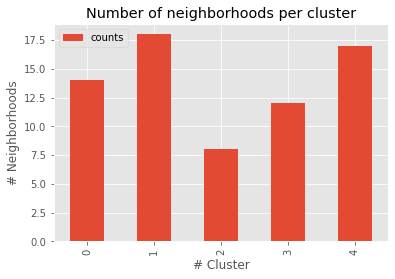

In [101]:
# plot data
stat2.plot(kind='bar', figsize=(6, 4))

plt.xlabel('# Cluster') # add to x-label to the plot
plt.ylabel('# Neighborhoods') # add y-label to the plot
plt.title('Number of neighborhoods per cluster') # add title to the plot

plt.show()

Text(0.5, 1.0, 'Population per Cluster')

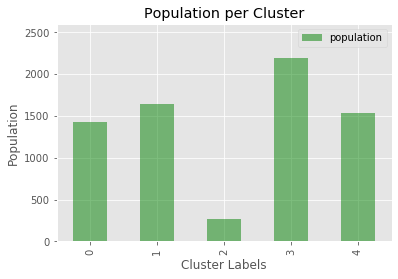

In [103]:
# Population
population = stat1['population']
ax0 = stat1.plot(kind='bar',
                    x='Cluster Labels',
                    y='population',
                    figsize=(6, 4),
                    alpha=0.5,                  # transparency
                    color='green',
                    ylim=(0, 2600))

ax0.set_ylabel('Population')
ax0.set_title('Population per Cluster')

### Exam new clusters

#### Cluster 0

In [146]:
cluster0 = paris_merged1.loc[paris_merged1['Cluster Labels'] == 0, paris_merged1.columns[[0] + list(range(5, paris_merged1.shape[1]))]]
cluster0

,neighborhood,borough,postal_code,borough_name,population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Petit-Montrouge,14,75014,PARIS-14E-ARRONDISSEMENT,137.2,0,Hotel,French Restaurant,Supermarket,Italian Restaurant,Japanese Restaurant,Plaza,Lawyer,Sushi Restaurant,Bus Stop,Sandwich Place
4,Chaillot,16,75016,PARIS-16E-ARRONDISSEMENT,169.4,0,Hotel,French Restaurant,Italian Restaurant,Bakery,Café,Art Museum,Japanese Restaurant,Pub,Chinese Restaurant,Salad Place
11,Europe,08,75008,PARIS-8E-ARRONDISSEMENT,40.3,0,French Restaurant,Hotel,Italian Restaurant,Bar,Bakery,Theater,Café,Bistro,Restaurant,Japanese Restaurant
18,Saint-Vincent-de-Paul,10,75010,PARIS-10E-ARRONDISSEMENT,95.9,0,French Restaurant,Hotel,Indian Restaurant,Convenience Store,Sandwich Place,Bakery,Bar,Italian Restaurant,Pizza Place,Cosmetics Shop
21,Montparnasse,14,75014,PARIS-14E-ARRONDISSEMENT,137.2,0,Hotel,French Restaurant,Bistro,Bar,Italian Restaurant,Café,Sushi Restaurant,Bakery,Pizza Place,Supermarket
24,Saint-Georges,09,75009,PARIS-9E-ARRONDISSEMENT,60.3,0,Hotel,French Restaurant,Italian Restaurant,Cocktail Bar,Japanese Restaurant,Lounge,Theater,Bar,Pizza Place,Plaza
30,Ecole-Militaire,07,75007,PARIS-7E-ARRONDISSEMENT,57.4,0,Hotel,French Restaurant,Plaza,Asian Restaurant,Bistro,Garden,Rental Car Location,Furniture / Home Store,Farmers Market,Gym
31,Grenelle,15,75015,PARIS-15E-ARRONDISSEMENT,236.5,0,Hotel,Japanese Restaurant,French Restaurant,Pizza Place,Korean Restaurant,Italian Restaurant,Supermarket,Bistro,Bakery,Sandwich Place
35,Place-Vendôme,01,75001,PARIS-1ER-ARRONDISSEMENT,17.6,0,French Restaurant,Hotel,Jewelry Store,Japanese Restaurant,Chocolate Shop,Boutique,Dessert Shop,Hotel Bar,Tea Room,Bookstore
44,Plaisance,14,75014,PARIS-14E-ARRONDISSEMENT,137.2,0,Hotel,French Restaurant,Bakery,Café,Pizza Place,Bistro,Supermarket,Bar,Korean Restaurant,Grocery Store


In [105]:
# install wordcloud
!conda install -c conda-forge wordcloud==1.4.1 --yes

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

print ('Wordcloud is installed and imported!')

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - wordcloud==1.4.1


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    olefile-0.46               |             py_0          31 KB  conda-forge
    pillow-7.1.2               |   py36h8328e55_0         656 KB  conda-forge
    wordcloud-1.4.1            |           py36_0         324 KB  conda-forge
    ------------------------------------------------------------
                                           Total:        1011 KB

The following NEW packages will be INSTALLED:

  olefile            conda-forge/noarch::olefile-0.46-py_0
  pillow             conda-forge/linux-64::pillow-7.1.2-py36h8328e55_0
  wordcloud          conda-forge/linux-64::wordcloud-1.4.1-py36_0



pil

In [172]:
cluster0_mod = cluster0.drop(cluster0.columns[[0, 1, 2, 3, 4, 5]], axis=1)
cluster0_mod = cluster0_mod[['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue']]
cluster0_mod = cluster0_mod.to_csv('cluster0_mod.txt', sep='\t', index=False)
cluster0_mod = open('cluster0_mod.txt', 'r').read()

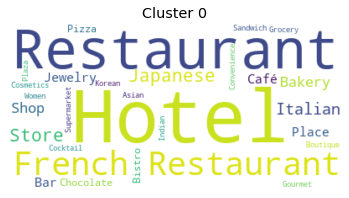

In [173]:
stopwords = {"Common", "Venue", "Most", "1st", "2nd", "3rd", "4th", "5th", "6th", "7th", "8th", "9th", "10th"}
# instantiate a word cloud object
cluster0_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords)

# generate the word cloud
cluster0_wc.generate(cluster0_mod)

# display the word cloud
plt.imshow(cluster0_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Cluster 0')
plt.show()

#### Cluster 1

In [149]:
cluster1 = paris_merged1.loc[paris_merged1['Cluster Labels'] == 1, paris_merged1.columns[[0] + list(range(5, paris_merged1.shape[1]))]]
cluster1

,neighborhood,borough,postal_code,borough_name,population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Notre-Dame-des-Champs,06,75006,PARIS-6E-ARRONDISSEMENT,43.1,1,French Restaurant,Hotel,Bakery,Japanese Restaurant,Italian Restaurant,Bistro,Creperie,Steakhouse,Chocolate Shop,Theater
14,Saint-Lambert,15,75015,PARIS-15E-ARRONDISSEMENT,236.5,1,French Restaurant,Hotel,Pizza Place,Supermarket,Italian Restaurant,Bus Stop,Asian Restaurant,Sushi Restaurant,Bakery,Café
17,Saint-Germain-des-Prés,06,75006,PARIS-6E-ARRONDISSEMENT,43.1,1,French Restaurant,Hotel,Italian Restaurant,Japanese Restaurant,Bistro,Cosmetics Shop,Plaza,Wine Bar,Sandwich Place,Café
22,Plaine de Monceaux,17,75017,PARIS-17E-ARRONDISSEMENT,168.5,1,French Restaurant,Hotel,Bakery,Italian Restaurant,Bistro,Supermarket,Café,Restaurant,Plaza,Pizza Place
27,Rochechouart,09,75009,PARIS-9E-ARRONDISSEMENT,60.3,1,French Restaurant,Hotel,Bakery,Restaurant,Italian Restaurant,Bar,Coffee Shop,Record Shop,Thai Restaurant,Pizza Place
39,Arsenal,04,75004,PARIS-4E-ARRONDISSEMENT,28.2,1,French Restaurant,Hotel,Italian Restaurant,Gastropub,Park,Bakery,Tapas Restaurant,Seafood Restaurant,Plaza,Historic Site
46,Saint-Thomas-d'Aquin,07,75007,PARIS-7E-ARRONDISSEMENT,57.4,1,French Restaurant,Hotel,Italian Restaurant,Bakery,Chocolate Shop,Bistro,Tea Room,Café,Restaurant,Cheese Shop
50,Saint-Victor,05,75005,PARIS-5E-ARRONDISSEMENT,61.5,1,French Restaurant,Hotel,Bakery,Bar,Bistro,Japanese Restaurant,Pub,Wine Bar,Plaza,Park
55,Invalides,07,75007,PARIS-7E-ARRONDISSEMENT,57.4,1,French Restaurant,Plaza,Hotel,Café,History Museum,Art Museum,Bike Rental / Bike Share,Italian Restaurant,Bistro,Park
56,Faubourg-Montmartre,09,75009,PARIS-9E-ARRONDISSEMENT,60.3,1,French Restaurant,Hotel,Wine Bar,Burger Joint,Japanese Restaurant,Pedestrian Plaza,Pizza Place,Empanada Restaurant,Sandwich Place,Candy Store


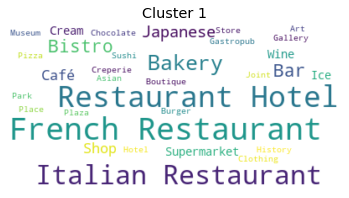

In [171]:
cluster1_mod = cluster1.drop(cluster1.columns[[0, 1, 2, 3, 4, 5]], axis=1)
cluster1_mod = cluster1_mod[['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue']]
cluster1_mod = cluster1_mod.to_csv('cluster1_mod.txt', sep='\t', index=False)
cluster1_mod = open('cluster1_mod.txt', 'r').read()
stopwords = {"Common", "Venue", "Most", "1st", "2nd", "3rd", "4th", "5th", "6th", "7th", "8th", "9th", "10th"}
# instantiate a word cloud object
cluster1_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords)

# generate the word cloud
cluster1_wc.generate(cluster1_mod)

# display the word cloud
plt.imshow(cluster1_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Cluster 1')
plt.show()

#### Cluster 2

In [151]:
cluster2 = paris_merged1.loc[paris_merged1['Cluster Labels'] == 2, paris_merged1.columns[[0] + list(range(5, paris_merged1.shape[1]))]]
cluster2

,neighborhood,borough,postal_code,borough_name,population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Mail,02,75002,PARIS-2E-ARRONDISSEMENT,22.4,2,French Restaurant,Cocktail Bar,Bakery,Italian Restaurant,Wine Bar,Coffee Shop,Creperie,Hotel,Japanese Restaurant,Indie Movie Theater
7,Bonne-Nouvelle,02,75002,PARIS-2E-ARRONDISSEMENT,22.4,2,Cocktail Bar,French Restaurant,Bakery,Wine Bar,Italian Restaurant,Hotel,Bar,Coffee Shop,Thai Restaurant,Pastry Shop
16,Enfants-Rouges,03,75003,PARIS-3E-ARRONDISSEMENT,35.7,2,French Restaurant,Bistro,Coffee Shop,Art Gallery,Wine Bar,Clothing Store,Bookstore,Café,Sandwich Place,Cocktail Bar
25,Chaussée-d'Antin,09,75009,PARIS-9E-ARRONDISSEMENT,60.3,2,French Restaurant,Hotel,Salad Place,Clothing Store,Coffee Shop,Women's Store,Boutique,Theater,Chocolate Shop,Creperie
45,Saint-Gervais,04,75004,PARIS-4E-ARRONDISSEMENT,28.2,2,French Restaurant,Clothing Store,Hotel,Pastry Shop,Gourmet Shop,Wine Bar,Ice Cream Shop,Plaza,Pub,Coffee Shop
66,Archives,03,75003,PARIS-3E-ARRONDISSEMENT,35.7,2,Clothing Store,Art Gallery,Japanese Restaurant,French Restaurant,Coffee Shop,Italian Restaurant,Boutique,Café,Sandwich Place,Bakery
68,Saint-Merri,04,75004,PARIS-4E-ARRONDISSEMENT,28.2,2,Art Gallery,Bakery,Ice Cream Shop,Plaza,Clothing Store,Cosmetics Shop,Pastry Shop,Bar,Gay Bar,French Restaurant
72,Sainte-Avoie,03,75003,PARIS-3E-ARRONDISSEMENT,35.7,2,French Restaurant,Bakery,Coffee Shop,Cocktail Bar,Chinese Restaurant,Restaurant,Japanese Restaurant,Café,Art Gallery,Deli / Bodega


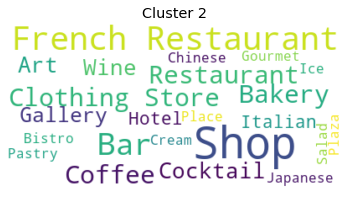

In [170]:
cluster2_mod = cluster2.drop(cluster2.columns[[0, 1, 2, 3, 4, 5]], axis=1)
cluster2_mod = cluster2_mod[['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue']]
cluster2_mod = cluster2_mod.to_csv('cluster2_mod.txt', sep='\t', index=False)
cluster2_mod = open('cluster2_mod.txt', 'r').read()
stopwords = {"Common", "Venue", "Most", "1st", "2nd", "3rd", "4th", "5th", "6th", "7th", "8th", "9th", "10th"}
# instantiate a word cloud object
cluster2_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords)

# generate the word cloud
cluster2_wc.generate(cluster2_mod)

# display the word cloud
plt.imshow(cluster2_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Cluster 2')
plt.show()

#### Cluster 3

In [153]:
cluster3 = paris_merged1.loc[paris_merged1['Cluster Labels'] == 3, paris_merged1.columns[[0] + list(range(5, paris_merged1.shape[1]))]]
cluster3

,neighborhood,borough,postal_code,borough_name,population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Pont-de-Flandre,19,75019,PARIS-19E-ARRONDISSEMENT,184.8,3,French Restaurant,Bike Rental / Bike Share,Supermarket,Café,Tram Station,Hotel,Asian Restaurant,Rock Club,Photography Studio,Movie Theater
5,Epinettes,17,75017,PARIS-17E-ARRONDISSEMENT,168.5,3,Supermarket,French Restaurant,Pizza Place,Bakery,Restaurant,Fast Food Restaurant,Bike Rental / Bike Share,Bar,Japanese Restaurant,Hotel
8,Gare,13,75013,PARIS-13E-ARRONDISSEMENT,182.0,3,Hotel,Restaurant,Supermarket,French Restaurant,Sandwich Place,Japanese Restaurant,Wine Shop,Vietnamese Restaurant,Italian Restaurant,Café
10,Goutte-d'Or,18,75018,PARIS-18E-ARRONDISSEMENT,200.6,3,Bar,Plaza,Café,Fast Food Restaurant,Theater,Pizza Place,Asian Restaurant,Chinese Restaurant,Supermarket,Sushi Restaurant
13,Parc-de-Montsouris,14,75014,PARIS-14E-ARRONDISSEMENT,137.2,3,Bike Rental / Bike Share,Italian Restaurant,Hotel,Bus Stop,Japanese Restaurant,Theater,Furniture / Home Store,Snack Place,Lebanese Restaurant,Bank
28,Bercy,12,75012,PARIS-12E-ARRONDISSEMENT,142.9,3,Hotel,French Restaurant,Bike Rental / Bike Share,Bakery,Italian Restaurant,Sushi Restaurant,Japanese Restaurant,Café,Supermarket,Convenience Store
34,Salpêtrière,13,75013,PARIS-13E-ARRONDISSEMENT,182.0,3,Bar,French Restaurant,Supermarket,Indian Restaurant,Hotel,Electronics Store,Café,Gym / Fitness Center,Korean Restaurant,Chinese Restaurant
37,Charonne,20,75020,PARIS-20E-ARRONDISSEMENT,197.1,3,Grocery Store,Supermarket,Bike Rental / Bike Share,Japanese Restaurant,Tram Station,French Restaurant,Park,Pizza Place,Construction & Landscaping,Bar
38,Javel,15,75015,PARIS-15E-ARRONDISSEMENT,236.5,3,French Restaurant,Supermarket,Pizza Place,Bike Rental / Bike Share,Bakery,Bistro,Bar,Sushi Restaurant,Hotel,Health Food Store
49,Villette,19,75019,PARIS-19E-ARRONDISSEMENT,184.8,3,Hotel,Bar,Café,Italian Restaurant,French Restaurant,Supermarket,Asian Restaurant,Fast Food Restaurant,Bistro,Multiplex


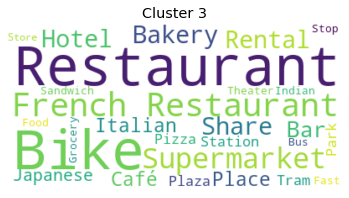

In [169]:
cluster3_mod = cluster3.drop(cluster3.columns[[0, 1, 2, 3, 4, 5]], axis=1)
cluster3_mod = cluster3_mod[['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue']]
cluster3_mod = cluster3_mod.to_csv('cluster3_mod.txt', sep='\t', index=False)
cluster3_mod = open('cluster3_mod.txt', 'r').read()
stopwords = {"Common", "Venue", "Most", "1st", "2nd", "3rd", "4th", "5th", "6th", "7th", "8th", "9th", "10th"}
# instantiate a word cloud object
cluster3_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords)

# generate the word cloud
cluster3_wc.generate(cluster3_mod)

# display the word cloud
plt.imshow(cluster3_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Cluster 3')
plt.show()

#### Cluster 4

In [156]:
cluster4 = paris_merged1.loc[paris_merged1['Cluster Labels'] == 4, paris_merged1.columns[[0] + list(range(5, paris_merged1.shape[1]))]]
cluster4

,neighborhood,borough,postal_code,borough_name,population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Clignancourt,18,75018,PARIS-18E-ARRONDISSEMENT,200.6,4,French Restaurant,Bar,Pizza Place,Bistro,Italian Restaurant,Café,Japanese Restaurant,Restaurant,Bakery,Indian Restaurant
12,Sainte-Marguerite,11,75011,PARIS-11E-ARRONDISSEMENT,152.7,4,French Restaurant,Bar,Hotel,Bistro,Italian Restaurant,Restaurant,Bookstore,Arts & Crafts Store,Supermarket,Brasserie
15,Vivienne,02,75002,PARIS-2E-ARRONDISSEMENT,22.4,4,French Restaurant,Japanese Restaurant,Wine Bar,Italian Restaurant,Hotel,Clothing Store,Bistro,Creperie,Bookstore,Bakery
23,Sorbonne,05,75005,PARIS-5E-ARRONDISSEMENT,61.5,4,French Restaurant,Hotel,Bookstore,Bakery,Bar,Plaza,Pub,Coffee Shop,Mexican Restaurant,Burger Joint
26,Palais-Royal,01,75001,PARIS-1ER-ARRONDISSEMENT,17.6,4,Japanese Restaurant,Hotel,French Restaurant,Wine Bar,Italian Restaurant,Plaza,Café,Cosmetics Shop,Coffee Shop,Udon Restaurant
29,Halles,01,75001,PARIS-1ER-ARRONDISSEMENT,17.6,4,French Restaurant,Italian Restaurant,Pizza Place,Restaurant,Hotel,Bakery,Bar,Tea Room,Wine Bar,Clothing Store
40,Jardin-des-Plantes,05,75005,PARIS-5E-ARRONDISSEMENT,61.5,4,French Restaurant,Hotel,Café,Italian Restaurant,Science Museum,Garden,Tea Room,Bar,Moroccan Restaurant,Bakery
41,Porte-Saint-Martin,10,75010,PARIS-10E-ARRONDISSEMENT,95.9,4,Coffee Shop,French Restaurant,Hotel,Bar,Pizza Place,Furniture / Home Store,Bistro,Bakery,Tapas Restaurant,Italian Restaurant
42,Roquette,11,75011,PARIS-11E-ARRONDISSEMENT,152.7,4,French Restaurant,Bistro,Bar,Café,Italian Restaurant,Cocktail Bar,Pastry Shop,Wine Bar,Women's Store,Vietnamese Restaurant
47,Porte-Saint-Denis,10,75010,PARIS-10E-ARRONDISSEMENT,95.9,4,French Restaurant,Pizza Place,Bar,Italian Restaurant,Bistro,Indian Restaurant,Seafood Restaurant,Korean Restaurant,Burger Joint,Café


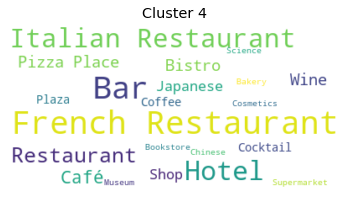

In [168]:
cluster4_mod = cluster4.drop(cluster4.columns[[0, 1, 2, 3, 4, 5]], axis=1)
cluster4_mod = cluster4_mod[['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue']]
cluster4_mod = cluster4_mod.to_csv('cluster4_mod.txt', sep='\t', index=False)
cluster4_mod = open('cluster4_mod.txt', 'r').read()
stopwords = {"Common", "Venue", "Most", "1st", "2nd", "3rd", "4th", "5th", "6th", "7th", "8th", "9th", "10th"}
# instantiate a word cloud object
cluster4_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords)

# generate the word cloud
cluster4_wc.generate(cluster4_mod)

# display the word cloud
plt.imshow(cluster4_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Cluster 4')
plt.show()

In [179]:
paris_merged1.to_csv('paris_merged1.csv', index=False)
!conda install -c conda-forge openpyxl --yes
paris_merged1.to_excel("paris_merged1.xlsx") 

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - openpyxl


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    et_xmlfile-1.0.1           |          py_1001          11 KB  conda-forge
    jdcal-1.4.1                |             py_0           9 KB  conda-forge
    openpyxl-3.0.3             |             py_0         152 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         172 KB

The following NEW packages will be INSTALLED:

  et_xmlfile         conda-forge/noarch::et_xmlfile-1.0.1-py_1001
  jdcal              conda-forge/noarch::jdcal-1.4.1-py_0
  openpyxl           conda-forge/noarch::openpyxl-3.0.3-py_0



et_xmlfile-1.0.1     | 11 KB     | ##################################### | 100% 
openpyxl-3.0.3       | 152

### The end! For the details and results please see the report.